# Check uncertainty estimates


[can't start cudnn algorithm](https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in)

In [1]:
# Extensions
%load_ext autoreload 

In [2]:
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split


BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

sys.path.append(MODULE_PATH)

from bayesian import McDropout, MomentPropagation
import data.mnist as mnist_loader

from data import BenchmarkData, DataSetType
import mp.MomentPropagation as mp

from models.default import default_model
from models.tf_growth import setup_growth

## Prepare Data

In [3]:
benchmark_data = BenchmarkData(DataSetType.MNIST, os.path.join(DATASET_PATH, "mnist"), classes=2)

In [4]:
benchmark_data.targets[:10]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(benchmark_data.inputs, benchmark_data.targets)

In [6]:
unique_classes = np.unique(benchmark_data.targets)

def print_label_count(targets, unique_labels, prefix="train"):
    print(prefix + "_labels: ")
    
    for label in unique_labels:
        count = (targets==label).sum()
        print("Label-{}: {}".format(label, count))
    
    print("-------------")

print_label_count(y_train, unique_classes)
print_label_count(y_test, unique_classes)

train_labels: 
Label-0: 5153
Label-1: 5932
-------------
train_labels: 
Label-0: 1750
Label-1: 1945
-------------


## Train and build models

In [7]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [8]:
model = default_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [2]:
model.fit(x_train, y_train, epochs=100)

NameError: name 'model' is not defined

## Evaluate performance

In [9]:
model.evaluate(x_test, y_test)

116/116 [==============================] - 2s 21ms/step - loss: 5.4962 - binary_accuracy: 0.5323


[5.496200084686279, 0.5323410034179688]

Predicted label: [[0.99999964]]


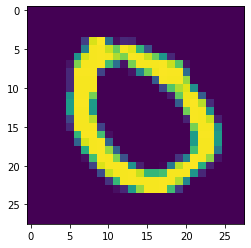

In [10]:
random_indx = np.random.choice(range(len(x_test)))

test_img = x_test[random_indx]
plt.imshow(test_img.reshape((28, 28)))

prediction = model(np.expand_dims(test_img, axis=0))

print("Predicted label: {}".format(prediction))

## Compare regular models

In [11]:
test_inputs = x_test[10:20]
test_targets = y_test[10:20]

test_targets

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0], dtype=uint8)

In [12]:
def check_shapes(inputs, targets):
    
    # Add batch dimension if single element given as 
    new_inputs = inputs
    if len(inputs.shape) == 3:
        new_inputs = np.expand_dims(inputs, axis=0)
        
    new_targets = targets
    if isinstance(test_targets, np.uint8):
        new_targets = np.array([targets])
    
    return new_inputs, new_targets

In [13]:
test_inputs, test_targets = check_shapes(test_inputs, test_targets)

In [14]:
# MP prediction
pred = []
runs = 10

for i in range(runs):
    pred.append(model(test_inputs, training=True))

pred = np.hstack(pred)

In [15]:
avg = np.average(pred, axis=1)
avg

array([0.9996084 , 0.9010212 , 0.9320754 , 0.9994774 , 0.9999994 ,
       0.99883497, 0.8822039 , 0.9994766 , 0.9994203 , 0.9008714 ],
      dtype=float32)

In [16]:
dp_model = McDropout(model)

In [17]:
np.average(dp_model.predict(test_inputs, runs=10), axis=1)

array([[9.99999869e-01, 1.31130219e-07],
       [9.51865071e-01, 4.81349289e-02],
       [9.96487641e-01, 3.51235867e-03],
       [9.99874699e-01, 1.25300884e-04],
       [9.99994063e-01, 5.93662262e-06],
       [9.99985409e-01, 1.45912170e-05],
       [9.95504165e-01, 4.49583530e-03],
       [9.94273758e-01, 5.72624207e-03],
       [9.24192666e-01, 7.58073345e-02],
       [9.91235095e-01, 8.76490474e-03]])

In [19]:
model = default_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
test_mp = mp.MP()
test_mp_model = test_mp.create_MP_Model(model=model, use_mp=False, verbose=False)

In [20]:
results = test_mp_model(test_inputs)
results

[<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.99999917],
        [1.        ],
        [0.99999404],
        [1.        ],
        [1.        ],
        [0.9999999 ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[3.0135800e-05],
        [0.0000000e+00],
        [1.5186102e-04],
        [0.0000000e+00],
        [0.0000000e+00],
        [4.0707214e-06],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32)>]

# Compare metrics

In [21]:
%autoreload 2
dp_model = McDropout(model)
mp_model = MomentPropagation(model)

In [22]:
values = dp_model.predict(test_inputs)

In [32]:
# mc dropout max_entropy
%autoreload 2
mc_max_entropy = dp_model.get_query_fn("max_entropy")(x_test[10:50], runs=10)
mc_max_entropy

array([-0.00096097, -0.0009995 , -0.00059155, -0.00099281, -0.00099931,
       -0.00099941, -0.00099931, -0.00099931, -0.00099809, -0.00099941,
       -0.00099941, -0.00099893, -0.00099724, -0.0009995 , -0.0009995 ,
       -0.00099912, -0.0009995 , -0.0009995 , -0.00099479,  0.00024259,
       -0.00099705, -0.00099696, -0.0009995 , -0.00099677, -0.00099799,
       -0.00093593, -0.00099592, -0.00099903, -0.0009995 , -0.0009995 ,
       -0.0009995 , -0.00097227, -0.00099931, -0.0009995 , -0.00099026,
       -0.00097217, -0.00099856, -0.0009995 , -0.00099922, -0.0009995 ])

In [34]:
# moment propagation max entropy
%autoreload 2
mp_max_entropy = mp_model.get_query_fn("max_entropy")(x_test[10:50])
mp_max_entropy

array([-0.00099295, -0.00099955, -0.00095245, -0.00099955, -0.00099955,
       -0.0009986 , -0.00099955, -0.00099955, -0.00099955, -0.00099955,
       -0.00099955, -0.0009986 , -0.00099955, -0.00099955, -0.00099955,
       -0.00099955, -0.00099955, -0.00099955, -0.00098353, -0.00099955,
       -0.00099578, -0.00099955, -0.00097505, -0.00093363, -0.00099955,
       -0.00099955, -0.00099955, -0.00099955, -0.00096469, -0.00099955,
       -0.00099955, -0.0009986 , -0.00099955, -0.00099955, -0.0009986 ,
       -0.00099955, -0.00099955, -0.00099955, -0.00098164, -0.0009986 ],
      dtype=float32)